In [2]:
import pandas as pd
import missingno as msno
from datetime import datetime
import numpy as np
import sklearn.compose._column_transformer
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
customers = pd.read_csv("../data/olist_customers_dataset.csv") # Client
geolocalisation = pd.read_csv("../data/olist_geolocation_dataset.csv") # Loc

order_items = pd.read_csv("../data/olist_order_items_dataset.csv") # Commandes items
order_payments = pd.read_csv("../data/olist_order_payments_dataset.csv") # Commandes paiement
order_reviews = pd.read_csv("../data/olist_order_reviews_dataset.csv") # Commandes reviews
orders = pd.read_csv("../data/olist_orders_dataset.csv") # Commandes

sellers = pd.read_csv("../data/olist_sellers_dataset.csv") # Vendeurs
products = pd.read_csv("../data/olist_products_dataset.csv") # Produits
cat_trans = pd.read_csv('../data/product_category_name_translation.csv') # Translate


In [4]:
order_cust = pd.merge(left=customers, right=orders, how="left", left_on="customer_id", right_on="customer_id")
forder_cust = pd.merge(left=order_cust, right=order_items, how="outer", left_on="order_id", right_on="order_id")

forder_cust['total'] = forder_cust[["price", "freight_value"]].sum(axis=1)

## Recence 

In [5]:
dates = ['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date']
forder_cust[dates] =forder_cust[dates].apply(pd.to_datetime, format='%Y-%m-%d')
date_1 = forder_cust.sort_values(by ='order_approved_at',ascending = False)


recence = date_1.groupby('customer_unique_id').agg(last_date =('order_approved_at','max')).reset_index()


recence['periode']=(date_1.order_approved_at.max()-recence.last_date).dt.days
recence.dropna(inplace=True)
recence.periode = recence.periode.astype(int)

def recence_transform(row):
    if row['periode'] <= 140:
        return 1
    if row['periode']> 140 and row['periode'] <= 280:
        return 2
    if row['periode']>280 and row['periode'] <= 420:
        return 3
    if row['periode']> 420 and row['periode'] <= 560:
        return 4
    if row['periode']> 560:
        return 5 

recence['r_value']=recence.apply(lambda row: recence_transform(row),axis=1)
recence.head()

,customer_unique_id,last_date,periode,r_value
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,116,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,118,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541,4
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,325,3
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,292,3


In [6]:

liste1 =cat_trans.product_category_name.tolist()
liste2 = cat_trans.product_category_name_english.tolist()
dict = {}
for key in liste1:
    for value in liste2:
        dict[key] = value
        liste2.remove(value)
        break
products.product_category_name=products.product_category_name.map(dict)
order_reviews.drop(['review_comment_title','review_comment_message'],inplace=True,axis=1)
order_reviews['review_score'].dropna(inplace=True)

## Merging pour l'analyse des commandes

### reajustement du df payments pour obtenir une ligne = une commande

In [7]:
def get_mode(x):
    return x.mode().iloc[0]

In [8]:
p1 = order_payments.groupby('order_id').agg(payment_installment = ('payment_installments',get_mode),payment_type = ('payment_type',get_mode),total_pay =('payment_value','sum')).reset_index()


<AxesSubplot:xlabel='payment_installment', ylabel='Count'>

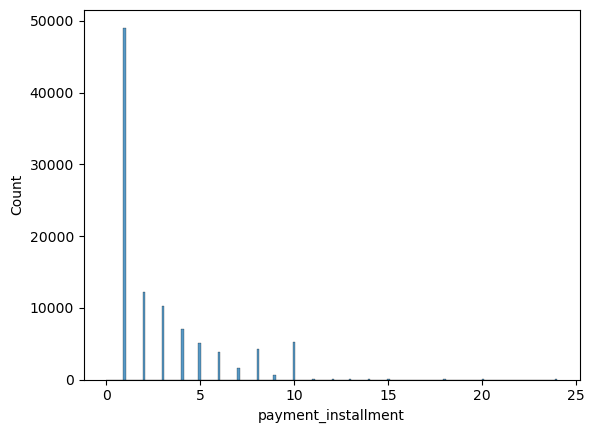

In [9]:
sns.histplot(data=p1,x='payment_installment')

### Merging products and order_items et les regrouper par commandes uniques

In [10]:
order_items.drop(['seller_id','price','freight_value'],inplace=True,axis=1)


In [11]:
products_item = pd.merge(order_items,products,how ='left',left_on='product_id',right_on='product_id')
a = products_item.groupby(['order_id','product_category_name']).agg(total_commande=('order_item_id','count'),prod =('product_id','nunique')).reset_index()
c = a.groupby('order_id').agg(category=('product_category_name',get_mode),items_commande = ('total_commande','sum'),prod_commande=('prod','sum')).reset_index()


### Merging orders_items/products/payments

In [12]:
df_commande = pd.merge(p1,c,how='left',left_on='order_id',right_on='order_id')
df_commande
#Dataframe montrant par commande , le type de paiement le plus utilisé, le total de la commande en R$, la catégorie du produit le plus commandé, le nb d'items commandé et le nombre de produits différents commandés

,order_id,payment_installment,payment_type,total_pay,category,items_commande,prod_commande
0,00010242fe8c5a6d1ba2dd792cb16214,2,credit_card,72.19,cool_stuff,1.0,1.0
1,00018f77f2f0320c557190d7a144bdd3,3,credit_card,259.83,pet_shop,1.0,1.0
2,000229ec398224ef6ca0657da4fc703e,5,credit_card,216.87,furniture_decor,1.0,1.0
3,00024acbcdf0a6daa1e931b038114c75,2,credit_card,25.78,perfumery,1.0,1.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3,credit_card,218.04,garden_tools,1.0,1.0
...,...,...,...,...,...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,1,boleto,343.40,housewares,1.0,1.0
99436,fffcd46ef2263f404302a634eb57f7eb,1,boleto,386.53,computers_accessories,1.0,1.0
99437,fffce4705a9662cd70adb13d4a31832d,3,credit_card,116.85,sports_leisure,1.0,1.0
99438,fffe18544ffabc95dfada21779c9644f,3,credit_card,64.71,computers_accessories,1.0,1.0


In [13]:
orders.groupby('order_id').agg(delais_approval = ())

TypeError: unsupported operand type(s) for -: 'str' and 'str'

### ok

In [ ]:
prorder_items = pd.merge(left=df,right=orders,how='left',left_on='order_id',right_on='order_id') #orders_items,orders,products
merged_review = pd.merge(left=prorder_items,right=order_reviews,how='inner',left_on='order_id',right_on='order_id')#review
merged_payment = pd.merge(left=merged_review,right=order_payments,how='inner',left_on='order_id',right_on='order_id')#payments
merged_customers = pd.merge(left=merged_payment,right=customers,how='inner',left_on='customer_id',right_on='customer_id')#rcustomers
merged_sellers = pd.merge(left=merged_customers ,right=sellers,how='inner',left_on='seller_id',right_on='seller_id')#sellers